# Imports

In [1]:
from scipy.io import loadmat

In [2]:
import numpy as np

In [77]:
import numpy.ma as ma

In [3]:
from numpy import linalg as LA

In [21]:
from PIL import Image

# Utility functions

In [34]:
def show_image(npimg):
    return Image.fromarray(npimg.astype(np.uint8))

In [35]:
def show_normals(npnorms):
    return Image.fromarray(((npnorms+1)/2*255).astype(np.uint8))

# Loading

In [4]:
mat = loadmat('../Code/Experiments/Outputs/VGG16.mat')

In [5]:
mat['Normals'].shape

(654, 240, 320, 3)

In [6]:
mat['Predictions'].shape

(654, 240, 320, 3)

# Evaluation

In [7]:
shape = mat['Normals'].shape

In [8]:
Norms = mat['Normals']

In [9]:
Norms = np.divide(Norms,np.reshape(LA.norm(Norms,axis=3), (shape[0],shape[1],shape[2],1)))

/home/raman/Applications/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [11]:
Norms = np.nan_to_num(Norms)

In [12]:
np.unique(LA.norm(Norms,axis=3))

array([ 0.        ,  0.99999988,  0.99999994,  1.        ,  1.00000012], dtype=float32)

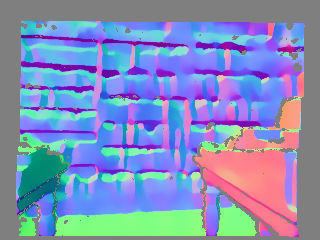

In [45]:
show_normals(Norms[39])

In [80]:
Masks = np.all(Norms,axis=3)

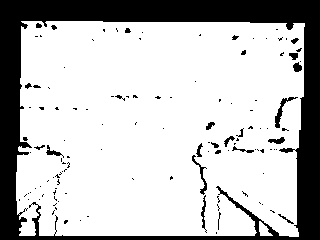

In [133]:
show_image(Masks[39]*255)

In [46]:
Preds = mat['Predictions']

In [47]:
Preds = np.divide(Preds,np.reshape(LA.norm(Preds,axis=3), (shape[0],shape[1],shape[2],1)))

/home/raman/Applications/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [48]:
Preds = np.nan_to_num(Preds)

In [49]:
np.unique(LA.norm(Preds,axis=3))

array([ 0.        ,  0.99999988,  0.99999994,  1.        ,  1.00000012], dtype=float32)

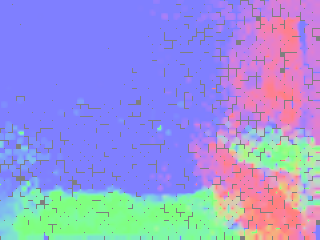

In [51]:
show_normals(Preds[39])

In [52]:
Dot = np.sum(np.multiply(Norms,Preds),axis=-1)

In [62]:
Dot.shape

(654, 240, 320)

In [53]:
Dot = np.clip(Dot, -1,1)

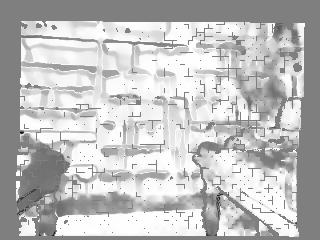

In [63]:
show_normals(Dot[39])

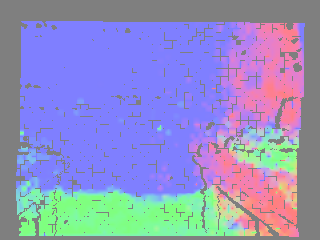

In [136]:
show_normals(Preds[39]*np.expand_dims(Masks[39], axis=2))

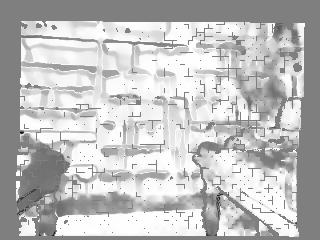

In [137]:
show_normals(Dot[39]*Masks[39])

In [138]:
Err = ma.masked_array(np.rad2deg(np.arccos(Dot)), ~Masks)

In [139]:
Err.mean()

41.355931809061389

In [141]:
np.mean(np.less(Err, 11.25).astype(np.float32))*100

12.458500597629401

In [142]:
Err = Err.compressed()

In [143]:
Summary = {'Mean':float(np.mean(Err)),
          'Median':float(np.median(Err)),
          'RMSE':float(np.sqrt(np.mean(np.power(Err,2)))),
          '11.25':np.mean(np.less(Err, 11.25).astype(np.float32))*100,
          '22.5':np.mean(np.less(Err, 22.5).astype(np.float32))*100,
          '30':np.mean(np.less(Err, 30).astype(np.float32))*100,
          '45':np.mean(np.less(Err, 45).astype(np.float32))*100}

In [144]:

Summary

{'11.25': 12.458500266075134,
 '22.5': 30.244261026382446,
 '30': 41.094136238098145,
 '45': 59.958332777023315,
 'Mean': 41.35591125488281,
 'Median': 36.82966995239258,
 'RMSE': 49.13106918334961}

In [145]:
import json

In [146]:
json.dumps(Summary)

'{"Mean": 41.35591125488281, "Median": 36.82966995239258, "RMSE": 49.13106918334961, "11.25": 12.458500266075134, "22.5": 30.244261026382446, "30": 41.094136238098145, "45": 59.958332777023315}'

# Code

In [147]:
%%writefile ../Code/Experiments/Evaluation.py
# Imports
import json
import numpy as np
import numpy.ma as ma
from numpy import linalg as LA

def Evaluate(ID, groundTruth, predictions):
    shape = groundTruth.shape
    # Normalization
    Norms = np.divide(groundTruth,np.reshape(LA.norm(groundTruth,axis=3), (shape[0],shape[1],shape[2],1)))
    Preds = np.divide(predictions,np.reshape(LA.norm(predictions,axis=3), (shape[0],shape[1],shape[2],1)))
    Norms = np.nan_to_num(Norms)
    Preds = np.nan_to_num(Preds)
    # Mask of valid values
    Masks = np.all(Norms,axis=3)
    # Dot product
    Dot = np.sum(np.multiply(Norms,Preds),axis=-1)
    Dot = np.clip(Dot, -1,1)
    # Error
    Err = np.rad2deg(np.arccos(Dot))
    Err = ma.masked_array(Err, ~Masks)
    Err = Err.compressed()
    # Stats
    Stats = {
        'Mean':float(np.mean(Err)),
        'Median':float(np.median(Err)),
        'RMSE':float(np.sqrt(np.mean(np.power(Err,2)))),
        '11.25':np.mean(np.less(Err, 11.25).astype(np.float32))*100,
        '22.5':np.mean(np.less(Err, 22.5).astype(np.float32))*100,
        '30':np.mean(np.less(Err, 30).astype(np.float32))*100,
        '45':np.mean(np.less(Err, 45).astype(np.float32))*100,}
    # Saving the results
    with open('Experiments/Outputs/'+ ID + '.eval', 'w') as fp:
        json.dump(Stats, fp)

Overwriting ../Code/Experiments/Evaluation.py
